<div>
<img src="images/icon_important.jpg" width="50" align="left"/>
</div>
<br>
<br>

#### __Important Legal Notice__
By running and editing this Jupyter notebook with the corresponding dataset, you agree that you will not use or store the data for other purposes than participating in the Champagne Coding with DNB & Women in Data Science, Oslo. You will delete the data and notebook after the event and will not attempt to identify any of the commentors.

### Anonymization

We've anonymized the data that was available from the start. Since there were names in some of the reviews, we decided to use the list of names from the scraped reviews and replace them with empty strings in the review text. Make sure that you always prioritize anonymization when working with potentially sensitive data :) 

In [1]:
flatten = lambda l: [item for sublist in l for item in sublist]

def remove_names(input_string, list_names):
    for n in list_names:
        input_string = input_string.replace(n.lower(), "")
        
    return input_string

def anonymization(df):
    """
    Create a list of names and search for them within the review text. 
    Replaces these names with blank strings.
    """
    # Store all of the names to a list
    all_names = df.Name.tolist()
    # Take the set of the list of names that are longer than 5
    names_list = list(set([n for n in all_names if len(n) > 5]))
    
    df.Review_Text = df.Review_Text.apply(lambda x: remove_names(str(x).lower(), names_list))
    
    return df

### Evaluating mobile app reviews

Here we will evaluate the mobile app reviews we scraped in the first notebook and:
- Analyse user sentiments using the comments and ratings
- Identify areas of interest among the reviews using topic modeling
- Explore and compare with other mobile app reviews

In [2]:
from pathlib import Path
current_directory = Path.cwd()
reviews_directory = Path(current_directory, 'reviews')

#### Let's start by reading in our reviews

In [3]:
import pandas as pd

In [4]:
df_dnb = pd.read_csv(Path(reviews_directory, 'dnb_reviews.csv'))

try:
    df_dnb = df_dnb.drop('Unnamed: 0', axis=1)
except:
    pass

df_dnb.head()

,Name,Date,Review_Score,Review_Text
0,Kapil sharma,"September 10, 2019",3,app is making my phone hang sevaral time ..als...
1,Gatos delamuerte,"August 21, 2019",4,"""SIM tool launches before the page is done loa..."
2,Daniel Kling,"August 21, 2019",1,Complete trash. Used to be ok. Its hardly an a...
3,Stig Martinus Fromreide,"August 16, 2019",3,I have been using the old and new version of t...
4,Kedron Thue,"August 27, 2019",1,Almost never works. Often try to log in but ge...


##### Read all the reviews in the directory and create a single dataframe

In [5]:
li = []
for f in Path(reviews_directory).glob("*.csv"):
    df = pd.read_csv(f)
    df['app_name'] = f.stem.replace('_reviews','')
    try:
        df.drop('Unnamed: 0', 
                axis = 1, 
                inplace=True)
    except:
        pass
    li.append(df)
    

df_all = pd.concat(li, 
                   axis=0)#, 
                   #ignore_index=True)

df_all.reset_index(inplace=True, drop=True)
df_all = anonymization(df_all)
df_all.head()

,Name,Date,Review_Score,Review_Text,app_name
0,Jesus Christ,"September 15, 2019",1,this app is worse than ever. it was a downgrad...,sbanken
1,Jens Chr Brynildsen,"September 6, 2019",1,crashes on startup. has been doing so for 2 mo...,sbanken
2,YouKay Agwu,"September 13, 2019",3,"nice and clean app, works 90% of the time. but...",sbanken
3,Dmitry Bigunyak,"November 8, 2018",2,the app from ui experience perspective is simp...,sbanken
4,David Griffiths,"February 1, 2019",1,since the last update the app has stopped func...,sbanken


Double check and delete duplicate records

In [6]:
df_all.drop_duplicates(inplace=True)
df_dnb.drop_duplicates(inplace=True)

#### Understanding our reviews

In [7]:
%matplotlib inline

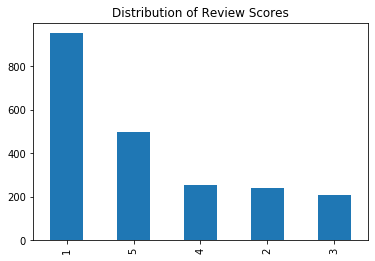

In [8]:
df_all.Review_Score.value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Distribution of Review Scores")

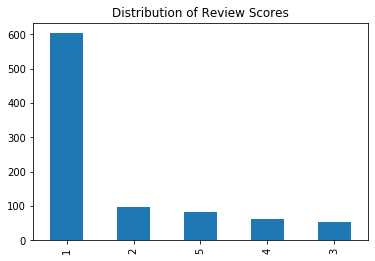

In [9]:
df_dnb.Review_Score.value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Distribution of Review Scores")

Ok, let's try to understand the breakdown of these scores and see if we see any trends.

In [10]:
df_review_scores_over_time = df.groupby(['Date','Review_Score']).size().unstack()

df_review_scores_over_time.index = pd.to_datetime(df_review_scores_over_time.index)
df_review_scores_over_time.sort_index(inplace = True)

df_review_scores_over_time = df_review_scores_over_time.fillna(0)

Let's filter DNB's applications since prior to November 2018, the application was a web-based site for mobile use.

In [11]:
df_review_scores_over_time = df_review_scores_over_time[df_review_scores_over_time.index > 
                                                        pd.to_datetime('2018-11-01')]

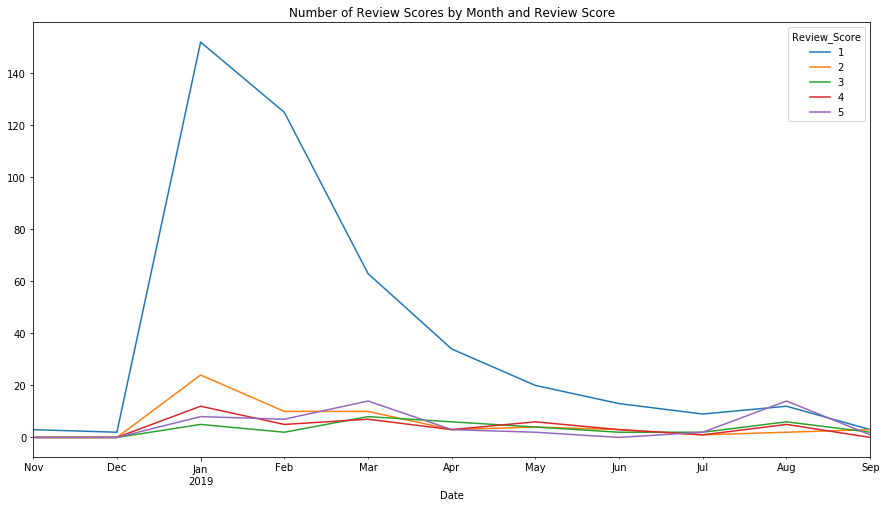

In [12]:
monthly = df_review_scores_over_time.groupby(pd.Grouper(freq="M")).sum()

monthly.plot(figsize=(15,8),
             title="Number of Review Scores by Month and Review Score")

## Topic Mining
#### Word Clouds

Let's get a feel for what are the major topics people mention. Before we start with topic mining, let's use a simple word cloud to see typical topics.

In [13]:
# Import the wordcloud library
from wordcloud import WordCloud

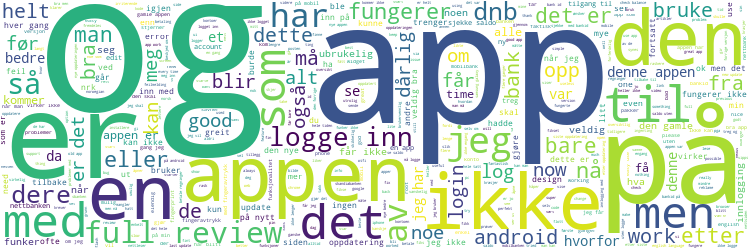

In [14]:
# Join the different processed titles together.
long_string = ",".join(str(i) for i in list(df_all.Review_Text.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      width=750,
                      height=250,
                      max_words=5000,
                      contour_width=3, 
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

What do you observe in this word cloud? I see a lot of typical words that should probably be filtered out before we mine for topics. 

In text analysis, we call these words ```stopwords```. We are fortunate to have libraries like nltk that have done a lot of the heavy lifting here for us, but we may have to add some more words to our list to get rid of words that aren't adding value to this analysis.

Let's start by exploring our out-of-the box options with ```nltk``` stopwords:

```
from nltk.corpus import stopwords
stopwords.words() # here you can also specify specific languages :) i.e. .words('english')
```
    
Should we include _all_ of the stopwords or just some _specific languages_? 

__TODO__: Check which languages are available. 

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [16]:
stopwords.words()[-20:]

['mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

How would you create your own set of stop words depending on the task?

In [17]:
our_stopwords = []
our_stopwords.append('app')
our_stopwords.append('appen')
our_stopwords.append('Full')
our_stopwords.append('Review')

Let's see how it changes our wordcloud if we add some of the un-interesting words to our list.

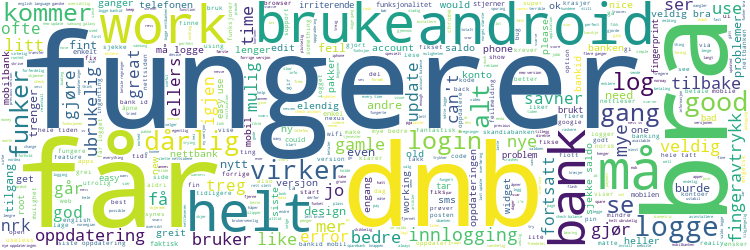

In [18]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      width=750,
                      height=250,
                      max_words=5000,
                      stopwords=stopwords.words('norwegian')+ stopwords.words('english')+ our_stopwords,
                      contour_width=3, 
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

__TODO:__ Create a word cloud for a couple of the applications

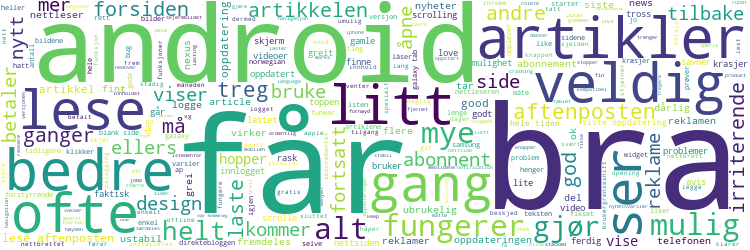

In [19]:
# Join the different processed titles together.
long_string_app = ",".join(str(i) for i in list(df_all[df_all.app_name=='aftenposten'].Review_Text.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      width=750,
                      height=250,
                      max_words=5000,
                      stopwords=stopwords.words('norwegian')+ stopwords.words('english')+ our_stopwords,
                      contour_width=3, 
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string_app)

# Visualize the word cloud
wordcloud.to_image()

In [20]:
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

How does using a different vectorizer change the results?

In [21]:
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('wordnet')

#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [22]:
def to_lowercase(words):
    """
    Convert all characters to lowercase from list of tokenized words
    """
    
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """
    Remove punctuation from list of tokenized words
    """
    
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


#def remove_numbers(words):
#    for word in words:
#        if word.isdigit():
#            # drop the word from the words
#            words

def remove_stopwords(words):
    """
    Remove stop words from list of tokenized words
    """
    
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """
    Stem words in list of tokenized words
    """
    
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """
    Lemmatize verbs in list of tokenized words
    """
    
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas



def pre_process(review_text):
    """
    A function that puts together our individual processes
    to pre-process our reviews.
    """
    
    # tokenize
    tokens = word_tokenize(review_text) 
    # lower case
    tokens = to_lowercase(tokens) 
    # remove punctuation
    tokens = remove_punctuation(tokens)
    # remove numbers
    
    # lemmatize / stem?
    
    # join all of the tokens
    tokens_sentence = ' '.join(tokens)
    
    return tokens_sentence

In [23]:
df_all.dropna(subset=['Review_Text'], inplace = True)
df_all['normalized_text'] = df_all.Review_Text.apply(lambda x: pre_process(x))

df_all.normalized_text.head()

0    this app is worse than ever it was a downgrade...
1    crashes on startup has been doing so for 2 mon...
2    nice and clean app works 90 of the time but no...
3    the app from ui experience perspective is simp...
4    since the last update the app has stopped func...
Name: normalized_text, dtype: object

## Count Vectorizer
### Let's convert our documents to a matrix of terms and their counts

Here we will use the ```CountVectorizer```. This will convert our documents to a matrix of token counts. __Note:__  if you do not specify any feature selection then the number of features will be equal to the vocabulary size found by analyzing the data. That might take a while to process (and a lot of memory!) if you have a large set of data.


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
count = CountVectorizer(stop_words=stopwords.words('norwegian')+
                        stopwords.words('english')+
                        our_stopwords)
count.fit(df_all.normalized_text)

count_matrix = count.fit_transform(df_all.normalized_text)

/Users/alexandrag/anaconda3/envs/champagne_coding/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['full', 'review'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [26]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, 
                 vectorizer, 
                 n_top_words):
    
    words = vectorizer.get_feature_names()
    
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

In [27]:
# Tweak the two parameters below
number_topics = 5
number_words = 5

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_matrix)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, 
             count, 
             number_words)

Topics found via LDA:

Topic #0:
review full bruke bank må

Topic #1:
får helt nye logge fungerer

Topic #2:
full virker dårlig fungerer review

Topic #3:
fungerer full review får android

Topic #4:
good nt veldig bra use


## TF-IDF Vectorizer
### Let's try a different vectorizer

Here we will use the TF-IDF vectorizer. TF-IDF stands for __term frequency - inverse document frequency__. This vectorizer will use the ```CountVectorizer``` class as we did in the previous step, but includes a transformation to calculate an appropriate weighting for our terms.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('norwegian')+
                        stopwords.words('english')+
                        our_stopwords)
tfidf.fit(df_all.normalized_text)

/Users/alexandrag/anaconda3/envs/champagne_coding/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['full', 'review'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['og', 'i', 'jeg', 'det', 'at', 'en', 'et', 'den',
                            'til', 'er', 'som', 'på', 'de', 'med', 'han', 'av',
                            'ikke', 'ikkje', 'der', 'så', 'var', 'meg', 'seg',
                            'men', 'ett', 'har', 'om', 'vi', 'min', 'mitt', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [30]:
tfidf_matrix = tfidf.fit_transform(df_all.normalized_text)

In [31]:
# Tweak the two parameters below
number_topics = 5
number_words = 5

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(tfidf_matrix)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, 
             tfidf, 
             number_words)

Topics found via LDA:

Topic #0:
nt work nice greit ca

Topic #1:
great fungerer virker funker bra

Topic #2:
logge får kommer helt ok

Topic #3:
good easy use english bedre

Topic #4:
bra veldig fungerer bank version


#### TODO: How might you improve the topics?

Starting points:
- More stopwords?
- Stricter vectorization rules?
- Translating?

#### TODO: How do topics vary by application and review score?

Starting points:
- Among those who are most positive, what do they mention?
- Among those who are most negative, what do they mention?